In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions.normal as normal
import torch.optim as optim
import matplotlib.pyplot as plt

#### NN

In [23]:
class NN(nn.Module):
    def __init__(self) -> None:
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, t):
        t = F.tanh(self.fc1(t))
        t = F.sigmoid(self.fc2(t))
        return t

    def predict(self, t):
        with torch.no_grad():
            t = self.forward(t)
        return t

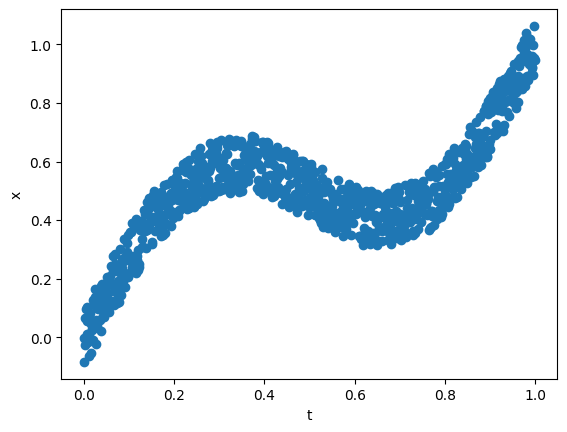

In [160]:
# x = t + 0.3 sin(2 * pi * t) + e
n = 1000
t = torch.arange(0, 1, 1/n)
e = 0.2 * torch.rand(n) - 0.1

x = t + 0.3 * torch.sin(2 * torch.pi * t) + e

plt.scatter(t, x)
plt.xlabel("t")
plt.ylabel("x")
plt.show()

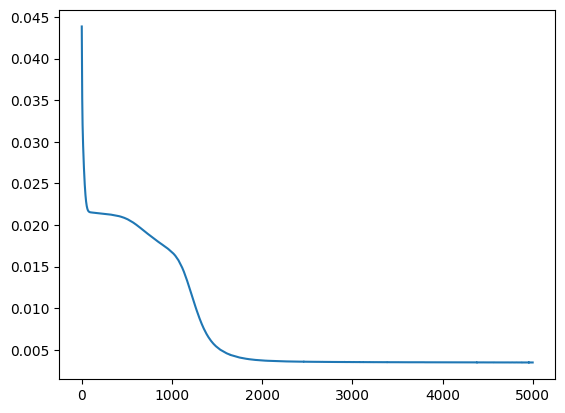

In [56]:
net = NN()
net.train()

optimizer = optim.Adam(net.parameters(), lr=0.001)
batch_size = 256
to_plot = []

for _ in range(5000):
    perm_idx = torch.randperm(len(x))
    t = t[perm_idx]
    x = x[perm_idx]

    for i in range(1000 // batch_size + 1):
        optimizer.zero_grad()

        inp = t[i * batch_size : (i + 1) * batch_size].view(-1, 1)
        target = x[i * batch_size : (i + 1) * batch_size]

        out = net.forward(inp)
        loss = torch.sum((target.view(-1) - out.view(-1)) ** 2) / target.shape[0]
        loss.backward()
        optimizer.step()

    to_plot.append(
        torch.sum((x.view(-1) - net.predict(t.view(-1, 1)).view(-1)) ** 2)
    .detach().numpy() / 1000)

plt.plot(to_plot)

Text(0, 0.5, 't')

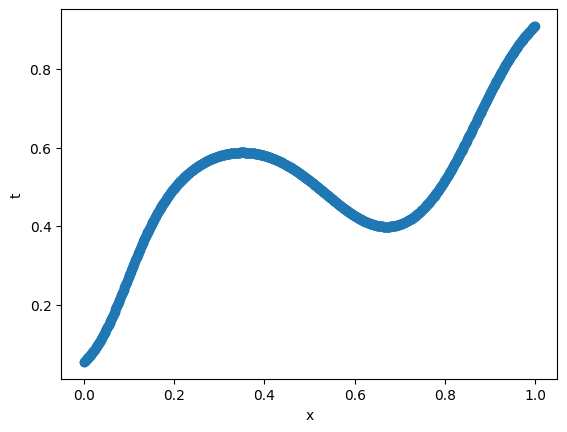

In [57]:
plt.scatter(t, net.predict(t.view(-1, 1)).detach().numpy())
plt.xlabel("x")
plt.ylabel("t")

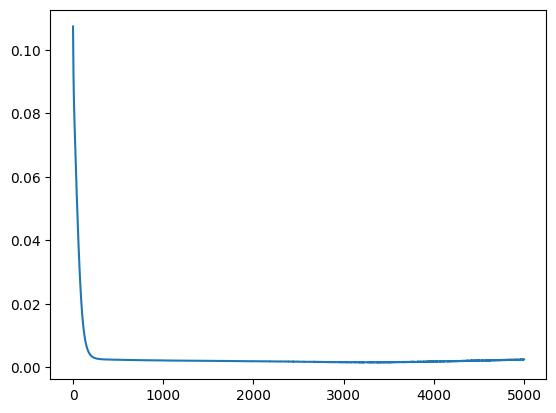

In [58]:
inv_net = NN()
inv_net.train()

optimizer = optim.Adam(inv_net.parameters(), lr=0.001)
batch_size = 256
to_plot = []

for _ in range(5000):
    perm_idx = torch.randperm(len(x))
    t = t[perm_idx]
    x = x[perm_idx]

    for i in range(1000 // batch_size + 1):
        optimizer.zero_grad()

        inp = x[i * batch_size : (i + 1) * batch_size].view(-1, 1)
        target = t[i * batch_size : (i + 1) * batch_size]

        out = inv_net.forward(inp)
        loss = torch.sum((target.view(-1) - out.view(-1)) ** 2) / target.shape[0]
        loss.backward()
        optimizer.step()

    to_plot.append(
        torch.sum((t.view(-1) - inv_net.predict(t.view(-1, 1)).view(-1)) ** 2)
    .detach().numpy() / 1000)

plt.plot(to_plot)

Text(0, 0.5, 't')

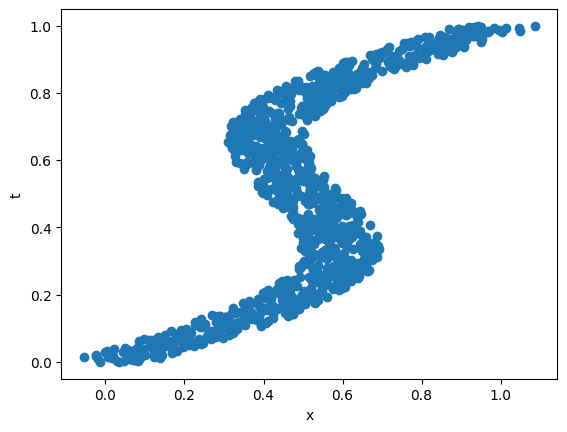

In [61]:
plt.scatter(x, t)
plt.xlabel("x")
plt.ylabel("t")

Text(0, 0.5, 't')

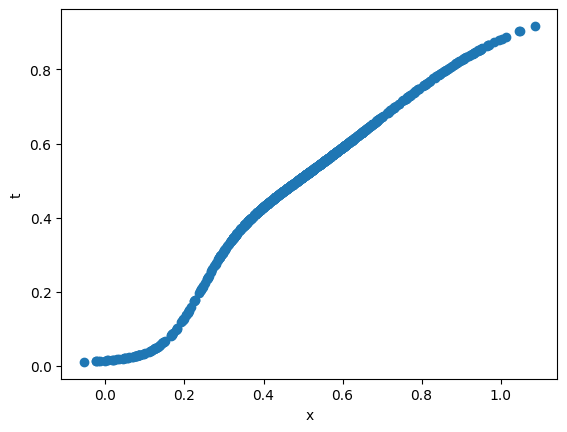

In [62]:
plt.scatter(x, inv_net.predict(x.view(-1, 1)).detach().numpy())
plt.xlabel("x")
plt.ylabel("t")

#### MDN

In [118]:
class MDN(nn.Module):
    def __init__(self) -> None:
        super(MDN, self).__init__()
        self.in_features = 1
        self.num_gaussians = 3

        self.fc1 = nn.Linear(self.in_features, 20)
        self.pi = nn.Linear(20, self.num_gaussians)
        self.sigma = nn.Linear(20, self.num_gaussians)
        self.mu = nn.Linear(20, self.num_gaussians)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        pis = F.softmax(self.pi(x), dim=1)
        sigmas = torch.exp(self.sigma(x))
        mus = self.mu(x)

        out = torch.cat((pis, sigmas, mus), dim=1)
        return out

    def predict(self, x):
        with torch.no_grad():
            t = self.forward(x)
        return t


In [114]:
def pdf(mdn, inp, target):
    out = mdn.predict(inp)
    pdf = 0
    for i in range(3):
        pi, sigma, mu = out[:, i], out[:, i+3], out[:, i+6]
        gaussian = normal.Normal(mu, sigma)
        phi = torch.exp(gaussian.log_prob(target.view(-1)))
        pdf += pi * phi

    return pdf

def calc_loss(mdn, inp, target):
    out = mdn.forward(inp)

    prob = 0  # not actually probability though
    for i in range(3):
        pi, sigma, mu = out[:, i], out[:, i+3], out[:, i+6]
        gaussian = normal.Normal(mu, sigma)
        phi = torch.exp(gaussian.log_prob(target.view(-1)))
        prob += pi * phi

    loss = torch.sum(- torch.log(prob))

    return loss


mdn = MDN()
inp = torch.tensor([0.2, 0.7]).view(-1, 1)
target = torch.tensor([0.5, 0.9]).view(-1, 1)

print(inp)
calc_loss(mdn, inp, target)

tensor([[0.2000],
        [0.7000]])


tensor(2.9612, grad_fn=<SumBackward0>)

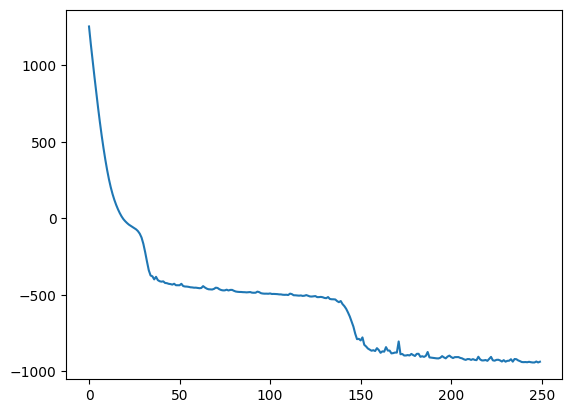

In [144]:
n = 1000
t = torch.arange(0, 1, 1/n)
e = 0.2 * torch.rand(n) - 0.1

x = t + 0.3 * torch.sin(2 * torch.pi * t) + e

mdn = MDN()
optimizer = optim.Adam(mdn.parameters(), lr=0.001)
batch_size = 128
to_plot = []
num_epochs = 250

for _ in range(num_epochs):
    perm_idx = torch.randperm(len(x))
    t = t[perm_idx]
    x = x[perm_idx]

    for i in range(1000 // batch_size + 1):
        optimizer.zero_grad()

        inp = x[i * batch_size : (i + 1) * batch_size].view(-1, 1)
        target = t[i * batch_size : (i + 1) * batch_size]

        loss = calc_loss(mdn, inp, target)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        to_plot.append(
            calc_loss(mdn, inp=x.view(-1, 1), target=t.view(-1, 1))
        )

plt.plot(to_plot)

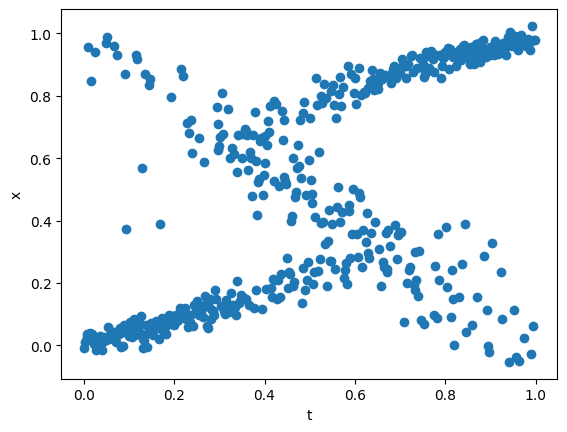

In [159]:
n = 500
x = torch.arange(0, 1, 1/n).view(-1, 1)
t = []

for i in range(len(x)):
    out = mdn.predict(x[i].view(-1, 1)).view(-1).detach().numpy()
    argmax_pi = np.random.choice(range(3), p=out[:3])
    mu = out[argmax_pi + 6]
    sigma = out[argmax_pi + 3]
    sample  = np.random.randn() * sigma + mu
    t.append(sample)

plt.scatter(x, t)
plt.xlabel("t")
plt.ylabel("x")
plt.show()